In [1]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.9 MB/s eta 0:00:00


In [2]:
import pandas as pd

In [3]:
lstm_results = pd.read_csv('/content/lstm_evaluation_results.csv')
gru_results = pd.read_csv('/content/gru_evaluation_results.csv')
tft_results = pd.read_csv('/content/tft_return_evaluation_results.csv')

In [4]:
lstm_results['model'] = 'lstm'
gru_results['model'] = 'gru'
tft_results['model'] = 'tft'

In [5]:
# Rbind lstm, gru and tft into only one dataframe
results_df = pd.concat([lstm_results, gru_results, tft_results])
results_df.head()

,Ticker,Accuracy,Precision,Recall,F1-Score,RMSE,model
0,FANG,0.475410,0.473684,0.442623,0.457627,0.018887,lstm
1,BKR,0.467213,0.447368,0.432203,0.439655,0.017553,lstm
2,CDNS,0.512295,0.504274,0.491667,0.497890,0.021943,lstm
3,CSCO,0.516393,0.495495,0.470085,0.482456,0.011769,lstm
4,MSTR,0.528689,0.500000,0.504348,0.502165,0.068132,lstm


In [13]:
import pandas as pd

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE']
stat_order  = ['min', 'mean', '50%', 'std', 'max', '25%', '75%']
stat_rename = {'min':'Min', 'mean':'Mean', '50%':'Median', 'std':'Std', 'max':'Max', '25%':'Q1', '75%':'Q3'}

desc = (
    results_df
    .groupby('model')[metrics]
    .describe(percentiles=[0.25, 0.5, 0.75])
)

# Reordenar y renombrar SOLO el nivel de estadístico (2º nivel)
desc = desc.loc[:, pd.IndexSlice[:, stat_order]]
desc = desc.rename(columns=stat_rename, level=1)

pretty = desc.round(4)   # <- tabla final
tidy = (
    desc   # ya reordenado y con nombres bonitos en la Opción A
    .stack(level=0)                         # pasa la métrica a filas
    .rename_axis(index=['model', 'Metric']) # renombra índices
    .reset_index()                          # a DataFrame
    .round(4)
)

# Asegura el orden de columnas
tidy = tidy[['model', 'Metric', 'Min', 'Mean', 'Median', 'Std', 'Max', 'Q1', 'Q3']]
print(tidy)

# (Opcional) Exportar
# tidy.to_csv('model_metric_summary.csv', index=False)
# Ejemplo de columnas: Accuracy_Mean, RMSE_Q1, ...

   model     Metric     Min    Mean  Median     Std     Max      Q1      Q3
0    gru   Accuracy  0.4221  0.4967  0.4959  0.0327  0.5779  0.4754  0.5205
1    gru   F1-Score  0.4107  0.4930  0.4915  0.0409  0.5929  0.4667  0.5280
2    gru  Precision  0.4000  0.4918  0.4876  0.0426  0.6198  0.4672  0.5200
3    gru       RMSE  0.0097  0.0230  0.0204  0.0117  0.0762  0.0145  0.0286
4    gru     Recall  0.4000  0.4950  0.4919  0.0439  0.5833  0.4609  0.5333
5   lstm   Accuracy  0.4303  0.5026  0.5000  0.0265  0.5656  0.4836  0.5205
6   lstm   F1-Score  0.4211  0.4990  0.4979  0.0330  0.5633  0.4797  0.5242
7   lstm  Precision  0.4016  0.4982  0.5000  0.0366  0.5763  0.4737  0.5271
8   lstm       RMSE  0.0101  0.0221  0.0188  0.0102  0.0681  0.0143  0.0279
9   lstm     Recall  0.4211  0.5008  0.4960  0.0368  0.5820  0.4758  0.5280
10   tft   Accuracy  0.3494  0.5376  0.5281  0.0759  0.7028  0.4779  0.5873
11   tft   F1-Score  0.3139  0.5348  0.5291  0.0779  0.6926  0.4816  0.5891
12   tft  Pr

/tmp/ipython-input-1758901883.py:20: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



In [14]:
import plotly.express as px
import pandas as pd

# Lista de métricas a comparar
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE']

for metric in metrics:
    df_long = pd.melt(results_df,
                      id_vars=['Ticker', 'model'],
                      value_vars=[metric],
                      var_name='Metric',
                      value_name='Value')

    fig = px.violin(df_long,
                    x='model',
                    y='Value',
                    color='model',
                    box=True,
                    points='all',
                    hover_data=['Ticker', 'model'])

    fig.update_layout(title=f'Comparativa de {metric} por modelo',
                      yaxis_title=metric,
                      xaxis_title='Modelo',
                      legend_title='Modelo',
                      width=900,
                      height=500)

    fig.show()

In [15]:
import pandas as pd
import numpy as np
from scipy import stats
import plotly.express as px

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE']
n_bootstrap = 1000
ci = 95
summary_list = []

for metric in metrics:
    print(f"\n📊 Summary para: {metric}")
    for model_name, group_df in results_df.groupby('model'):
        data = group_df[metric].dropna().values
        n = len(data)

        mean = np.mean(data)
        median = np.median(data)
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        min_ = np.min(data)
        max_ = np.max(data)

        # Bootstrap para IC de la media
        rng = np.random.default_rng(seed=42)
        boot_means = [np.mean(rng.choice(data, size=n, replace=True)) for _ in range(n_bootstrap)]
        mean_lower = np.percentile(boot_means, (100 - ci) / 2)
        mean_upper = np.percentile(boot_means, 100 - (100 - ci) / 2)

        # Bootstrap para IC de la mediana
        boot_medians = [np.median(rng.choice(data, size=n, replace=True)) for _ in range(n_bootstrap)]
        median_lower = np.percentile(boot_medians, (100 - ci) / 2)
        median_upper = np.percentile(boot_medians, 100 - (100 - ci) / 2)

        # Test de normalidad
        shapiro_stat, shapiro_p = stats.shapiro(data)
        normal = shapiro_p > 0.05

        print(f"\n📍 Modelo: {model_name}")
        print(f"n={n}")
        print(f"Mean: {mean:.4f} (IC {ci}%: {mean_lower:.4f}-{mean_upper:.4f})")
        print(f"Median: {median:.4f} (IC {ci}%: {median_lower:.4f}-{median_upper:.4f})")
        print(f"Q1: {q1:.4f}, Q3: {q3:.4f}")
        print(f"Min: {min_:.4f}, Max: {max_:.4f}")
        print(f"Shapiro-Wilk p={shapiro_p:.4f} → {'Normal' if normal else 'No normal'}")

        summary_list.append({
            'Metric': metric,
            'Model': model_name,
            'N': n,
            'Mean': mean,
            f'Mean_CI_{ci}_Lower': mean_lower,
            f'Mean_CI_{ci}_Upper': mean_upper,
            'Median': median,
            f'Median_CI_{ci}_Lower': median_lower,
            f'Median_CI_{ci}_Upper': median_upper,
            'Q1': q1,
            'Q3': q3,
            'Min': min_,
            'Max': max_,
            'Shapiro_p': shapiro_p,
            'Normal_Distribution': normal
        })

# Convertimos a DataFrame
summary_df = pd.DataFrame(summary_list)

print("\n✅ Resumen completo:")
print(summary_df.head())


📊 Summary para: Accuracy

📍 Modelo: gru
n=101
Mean: 0.4967 (IC 95%: 0.4905-0.5035)
Median: 0.4959 (IC 95%: 0.4877-0.5082)
Q1: 0.4754, Q3: 0.5205
Min: 0.4221, Max: 0.5779
Shapiro-Wilk p=0.5413 → Normal

📍 Modelo: lstm
n=101
Mean: 0.5026 (IC 95%: 0.4973-0.5077)
Median: 0.5000 (IC 95%: 0.4918-0.5082)
Q1: 0.4836, Q3: 0.5205
Min: 0.4303, Max: 0.5656
Shapiro-Wilk p=0.3355 → Normal

📍 Modelo: tft
n=100
Mean: 0.5376 (IC 95%: 0.5239-0.5519)
Median: 0.5281 (IC 95%: 0.5141-0.5542)
Q1: 0.4779, Q3: 0.5873
Min: 0.3494, Max: 0.7028
Shapiro-Wilk p=0.2247 → Normal

📊 Summary para: Precision

📍 Modelo: gru
n=101
Mean: 0.4918 (IC 95%: 0.4838-0.5005)
Median: 0.4876 (IC 95%: 0.4786-0.5085)
Q1: 0.4672, Q3: 0.5200
Min: 0.4000, Max: 0.6198
Shapiro-Wilk p=0.3428 → Normal

📍 Modelo: lstm
n=101
Mean: 0.4982 (IC 95%: 0.4911-0.5050)
Median: 0.5000 (IC 95%: 0.4915-0.5082)
Q1: 0.4737, Q3: 0.5271
Min: 0.4016, Max: 0.5763
Shapiro-Wilk p=0.6030 → Normal

📍 Modelo: tft
n=100
Mean: 0.5368 (IC 95%: 0.5206-0.5526)
Median:

In [16]:
from scipy.stats import mannwhitneyu
from itertools import combinations

# Lista para almacenar resultados
posthoc_results = []

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE']

for metric in metrics:
    print(f"\n🔍 Test post-hoc para: {metric}")

    # Obtenemos los modelos únicos
    models = results_df['model'].unique()

    # Todas las combinaciones de modelos (pares)
    for model1, model2 in combinations(models, 2):
        data1 = results_df[results_df['model'] == model1][metric].dropna()
        data2 = results_df[results_df['model'] == model2][metric].dropna()

        # Mann–Whitney U test
        stat, p_value = mannwhitneyu(data1, data2, alternative='two-sided')

        print(f"Comparando {model1} vs {model2} → p-value = {p_value:.4f}")

        posthoc_results.append({
            'Metric': metric,
            'Model_1': model1,
            'Model_2': model2,
            'p_value': p_value,
            'Significant (alpha=0.05)': p_value < 0.05
        })

# Convertimos a DataFrame
posthoc_df = pd.DataFrame(posthoc_results)

print("\n✅ Resumen post-hoc:")
print(posthoc_df)


🔍 Test post-hoc para: Accuracy
Comparando lstm vs gru → p-value = 0.2128
Comparando lstm vs tft → p-value = 0.0002
Comparando gru vs tft → p-value = 0.0000

🔍 Test post-hoc para: Precision
Comparando lstm vs gru → p-value = 0.2479
Comparando lstm vs tft → p-value = 0.0019
Comparando gru vs tft → p-value = 0.0001

🔍 Test post-hoc para: Recall
Comparando lstm vs gru → p-value = 0.2868
Comparando lstm vs tft → p-value = 0.0001
Comparando gru vs tft → p-value = 0.0000

🔍 Test post-hoc para: F1-Score
Comparando lstm vs gru → p-value = 0.2609
Comparando lstm vs tft → p-value = 0.0003
Comparando gru vs tft → p-value = 0.0000

🔍 Test post-hoc para: RMSE
Comparando lstm vs gru → p-value = 0.7162
Comparando lstm vs tft → p-value = 0.0000
Comparando gru vs tft → p-value = 0.0002

✅ Resumen post-hoc:
       Metric Model_1 Model_2   p_value  Significant (alpha=0.05)
0    Accuracy    lstm     gru  0.212790                     False
1    Accuracy    lstm     tft  0.000209                      True
2

In [19]:
import pandas as pd
import numpy as np
from scipy import stats
import pingouin as pg

# Tu DataFrame results_df ya debe estar cargado
# Verificar que existe el DataFrame
if 'results_df' not in locals():
    print("⚠️  Asegúrate de que tu DataFrame 'results_df' esté cargado")
    print("El DataFrame debe tener columnas: 'model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE'")
else:
    print(f"✅ DataFrame encontrado con {len(results_df)} filas y {len(results_df.columns)} columnas")
    print(f"Modelos únicos: {list(results_df['model'].unique())}")

# =========================
# 1) Mean + 95% CI per model
# =========================
def mean_ci(series, alpha=0.95):
    s = pd.Series(series).dropna()
    n = len(s)
    mean = s.mean()
    if n < 2:
        return pd.Series({'mean': mean, 'ci_lower': np.nan, 'ci_upper': np.nan, 'n': n})
    sem = stats.sem(s)
    lo, hi = stats.t.interval(alpha, df=n-1, loc=mean, scale=sem)
    return pd.Series({'mean': mean, 'ci_lower': lo, 'ci_upper': hi, 'n': n})

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE']

# Calcular estadísticas por modelo
summary_stats = (
    results_df.groupby('model')[metrics]
    .apply(lambda g: g.apply(mean_ci))
)

print("=" * 80)
print("RESUMEN ESTADÍSTICO POR MODELO")
print("=" * 80)

# Reorganizar los datos para una mejor presentación
for metric in metrics:
    print(f"\n📊 {metric.upper()}")
    print("-" * 60)

    # Crear tabla organizada
    metric_table = []
    for model in summary_stats.index.get_level_values(0).unique():
        try:
            stats_data = summary_stats.loc[model, metric]
            metric_table.append({
                'Modelo': model,
                'Media': stats_data['mean'],
                'IC_Inferior': stats_data['ci_lower'],
                'IC_Superior': stats_data['ci_upper'],
                'N': int(stats_data['n'])
            })
        except (KeyError, IndexError):
            continue

    if metric_table:
        df_metric = pd.DataFrame(metric_table)
        # Formatear las columnas numéricas
        for col in ['Media', 'IC_Inferior', 'IC_Superior']:
            df_metric[col] = df_metric[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
        print(df_metric.to_string(index=False))

# =========================
# 2) Comparaciones por pares mejoradas
# =========================
def calculate_mean_difference_ci(group1, group2, alpha=0.95):
    """Calcula la diferencia de medias y su IC"""
    diff = group2.mean() - group1.mean()

    # Pooled standard error
    n1, n2 = len(group1), len(group2)
    s1, s2 = group1.std(ddof=1), group2.std(ddof=1)

    # Welch's t-test approach for unequal variances
    se_diff = np.sqrt((s1**2/n1) + (s2**2/n2))

    # Degrees of freedom (Welch-Satterthwaite)
    df = ((s1**2/n1 + s2**2/n2)**2) / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))

    # Confidence interval
    t_crit = stats.t.ppf((1 + alpha)/2, df)
    ci_lower = diff - t_crit * se_diff
    ci_upper = diff + t_crit * se_diff

    return diff, ci_lower, ci_upper

print("\n" + "=" * 80)
print("COMPARACIONES POR PARES Modelo_2 - Modelo_1")
print("=" * 80)

unique_models = results_df['model'].dropna().unique()
if len(unique_models) < 2:
    print("\n❌ No hay suficientes grupos para comparar (se necesitan ≥ 2).")
else:
    for metric in metrics:
        print(f"\n🔍 {metric.upper()}")
        print("-" * 70)

        # Realizar comparaciones por pares con pingouin
        try:
            post = pg.pairwise_tests(
                dv=metric,
                between='model',
                data=results_df,
                parametric=True,
                padjust='bonf',
                effsize='cohen',
                alternative='two-sided'
            )

            # Crear tabla de comparaciones mejorada
            comparison_table = []
            for idx, row in post.iterrows():
                model1, model2 = row['A'], row['B']

                # Obtener los datos de cada grupo para calcular diferencias
                group1 = results_df[results_df['model'] == model1][metric].dropna()
                group2 = results_df[results_df['model'] == model2][metric].dropna()

                if len(group1) > 0 and len(group2) > 0:
                    diff, ci_lower, ci_upper = calculate_mean_difference_ci(group1, group2)

                    # Obtener p-valor corregido
                    p_corr = row.get('p-corr', row.get('p-adjust', np.nan))

                    # Determinar significancia
                    sig_level = "***" if p_corr < 0.001 else "**" if p_corr < 0.01 else "*" if p_corr < 0.05 else "ns"

                    comparison_table.append({
                        'Modelo_1': model1,
                        'Modelo_2': model2,
                        'Dif_Medias': diff,
                        'IC_Inf_Dif': ci_lower,
                        'IC_Sup_Dif': ci_upper,
                        'p_valor': p_corr,
                        'Significancia': sig_level
                    })

            if comparison_table:
                df_comparisons = pd.DataFrame(comparison_table)
                # Formatear las columnas numéricas
                numeric_cols = ['Dif_Medias', 'IC_Inf_Dif', 'IC_Sup_Dif', 'p_valor']
                for col in numeric_cols:
                    df_comparisons[col] = df_comparisons[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
                print(df_comparisons.to_string(index=False))

                # Agregar interpretación
                significant_comparisons = []
                for i, row in enumerate(comparison_table):
                    if row['Significancia'] != 'ns':
                        significant_comparisons.append(row)

                if significant_comparisons:
                    print(f"\n✅ Diferencias significativas encontradas: {len(significant_comparisons)}")
                    for comp in significant_comparisons:
                        p_val = comp['p_valor']
                        p_formatted = f"{p_val:.4f}" if pd.notna(p_val) else "N/A"
                        print(f"   • {comp['Modelo_1']} vs {comp['Modelo_2']}: p = {p_formatted} {comp['Significancia']}")
                else:
                    print(f"\n❌ No se encontraron diferencias significativas (p < 0.05)")

        except Exception as e:
            print(f"Error en el análisis de {metric}: {str(e)}")

# =========================
# 3) Resumen ejecutivo
# =========================
print("\n" + "=" * 80)
print("RESUMEN EJECUTIVO")
print("=" * 80)

print("\n📈 RENDIMIENTO GENERAL POR MODELO:")
print("-" * 40)

# Calcular ranking por métrica
for metric in metrics:
    print(f"\n{metric}:")
    metric_means = []
    for model in unique_models:
        model_data = results_df[results_df['model'] == model][metric].dropna()
        if len(model_data) > 0:
            metric_means.append((model, model_data.mean()))

    # Ordenar según la métrica (RMSE menor es mejor, el resto mayor es mejor)
    reverse_sort = metric != 'RMSE'
    metric_means.sort(key=lambda x: x[1], reverse=reverse_sort)

    for i, (model, mean_val) in enumerate(metric_means, 1):
        print(f"  {i}. {model}: {mean_val:.4f}")

print("\n" + "=" * 80)
print("Leyenda: *** p<0.001, ** p<0.01, * p<0.05, ns = no significativo")
print("IC = Intervalo de Confianza al 95%")
print("Dif_Medias = Modelo_2 - Modelo_1")
print("=" * 80)

✅ DataFrame encontrado con 302 filas y 7 columnas
Modelos únicos: ['lstm', 'gru', 'tft']
RESUMEN ESTADÍSTICO POR MODELO

📊 ACCURACY
------------------------------------------------------------
Modelo  Media IC_Inferior IC_Superior   N
   gru 0.4967      0.4902      0.5031 101
  lstm 0.5026      0.4974      0.5078 101
   tft 0.5376      0.5225      0.5526 100

📊 PRECISION
------------------------------------------------------------
Modelo  Media IC_Inferior IC_Superior   N
   gru 0.4918      0.4834      0.5002 101
  lstm 0.4982      0.4910      0.5054 101
   tft 0.5368      0.5200      0.5536 100

📊 RECALL
------------------------------------------------------------
Modelo  Media IC_Inferior IC_Superior   N
   gru 0.4950      0.4864      0.5037 101
  lstm 0.5008      0.4936      0.5081 101
   tft 0.5342      0.5191      0.5492 100

📊 F1-SCORE
------------------------------------------------------------
Modelo  Media IC_Inferior IC_Superior   N
   gru 0.4930      0.4850      0.5011 101
 

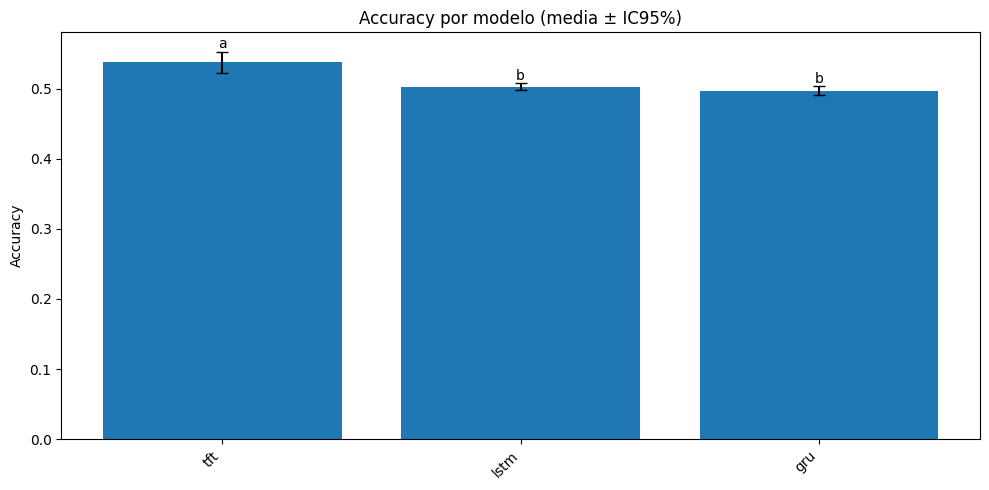

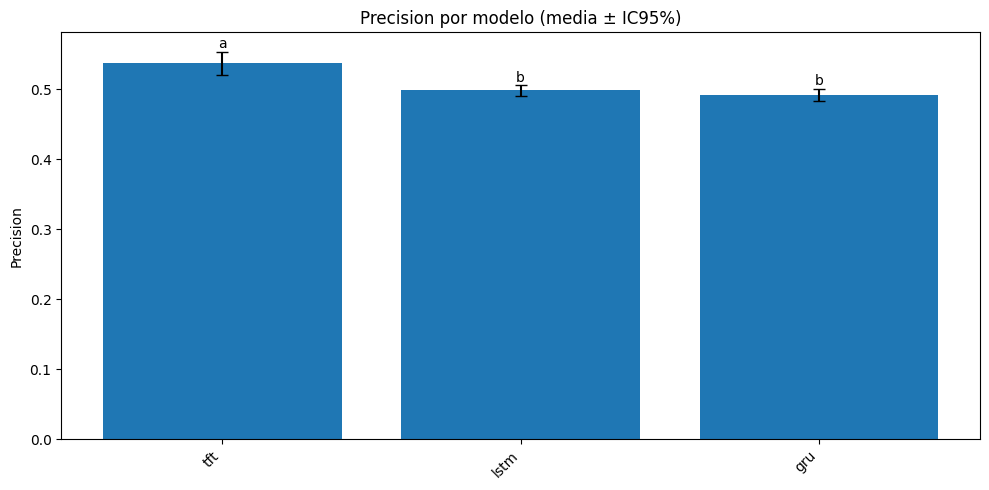

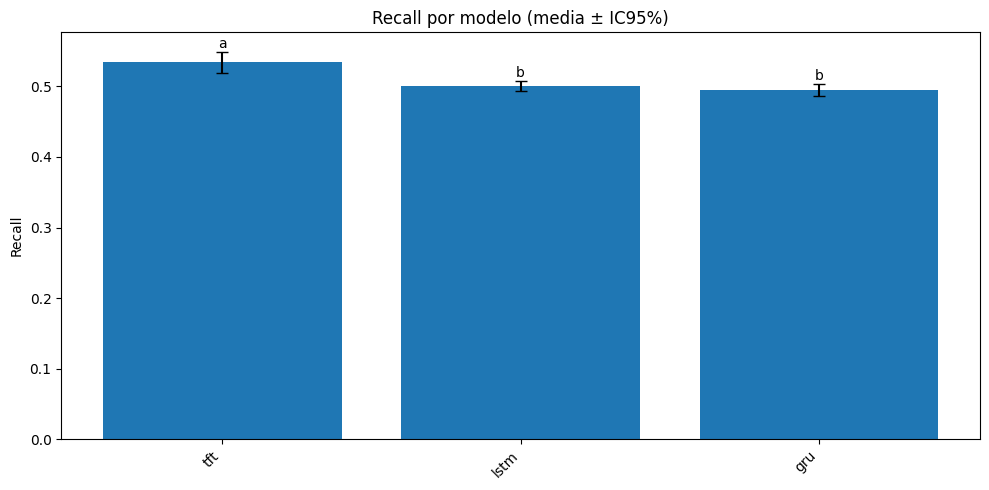

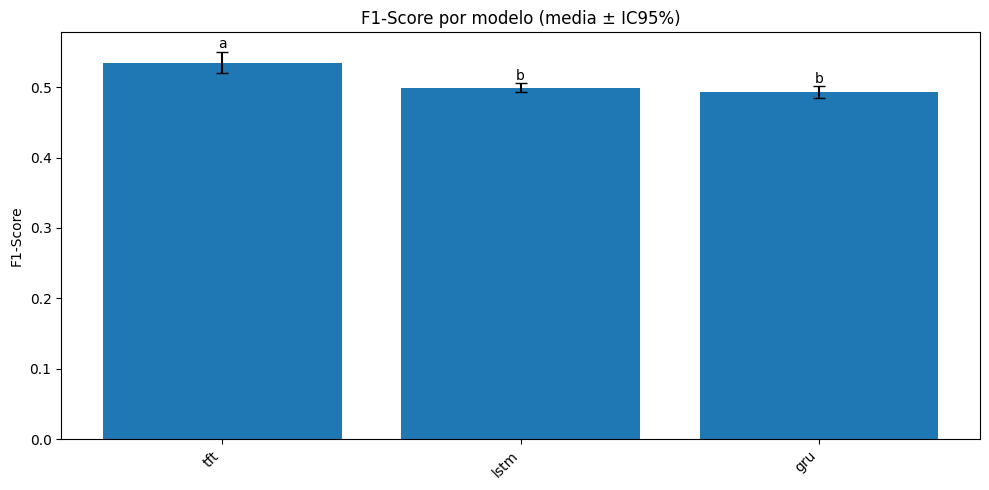

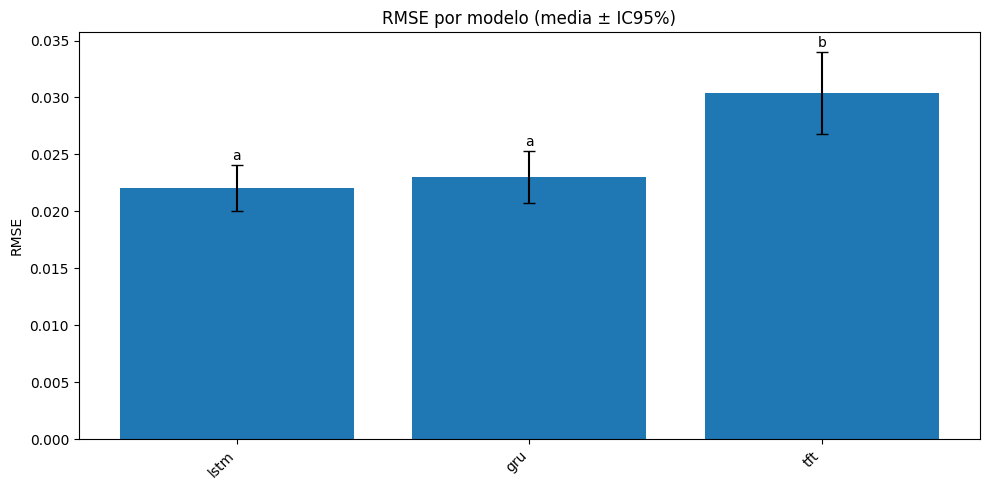


Accuracy: Media e IC95% por modelo (ordenado por desempeño)
model   Mean  CI_lower  CI_upper   N Group
  tft 0.5376    0.5225    0.5526 100     a
 lstm 0.5026    0.4974    0.5078 101     b
  gru 0.4967    0.4902    0.5031 101     b

Precision: Media e IC95% por modelo (ordenado por desempeño)
model   Mean  CI_lower  CI_upper   N Group
  tft 0.5368    0.5200    0.5536 100     a
 lstm 0.4982    0.4910    0.5054 101     b
  gru 0.4918    0.4834    0.5002 101     b

Recall: Media e IC95% por modelo (ordenado por desempeño)
model   Mean  CI_lower  CI_upper   N Group
  tft 0.5342    0.5191    0.5492 100     a
 lstm 0.5008    0.4936    0.5081 101     b
  gru 0.4950    0.4864    0.5037 101     b

F1-Score: Media e IC95% por modelo (ordenado por desempeño)
model   Mean  CI_lower  CI_upper   N Group
  tft 0.5348    0.5194    0.5503 100     a
 lstm 0.4990    0.4925    0.5055 101     b
  gru 0.4930    0.4850    0.5011 101     b

RMSE: Media e IC95% por modelo (ordenado por desempeño)
model   Mean

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ======================================================================================
# Requisitos: tener 'results_df' en memoria con columnas:
# 'model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE'
# ======================================================================================

# ---------------------- helpers ----------------------
def mean_ci_series(series, alpha=0.95):
    s = pd.Series(series).dropna()
    n = len(s)
    mean = s.mean()
    if n < 2:
        return mean, np.nan, np.nan, n
    sem = stats.sem(s)
    lo, hi = stats.t.interval(alpha, df=n-1, loc=mean, scale=sem)
    return mean, lo, hi, n

def pairwise_bonferroni_tests(df, metric):
    """Devuelve pares (A,B) y p-valores Bonferroni (Welch's t-test)."""
    models = sorted(df['model'].dropna().unique().tolist())
    pairs, pvals = [], []
    for i in range(len(models)):
        for j in range(i+1, len(models)):
            a, b = models[i], models[j]
            ga = df.loc[df['model']==a, metric].dropna()
            gb = df.loc[df['model']==b, metric].dropna()
            if len(ga) >= 2 and len(gb) >= 2:
                tstat, p = stats.ttest_ind(ga, gb, equal_var=False, alternative='two-sided')
            else:
                p = np.nan
            pairs.append((a, b))
            pvals.append(p)
    m = max(1, len(pvals))
    p_adj = [min(1.0, p*m) if not np.isnan(p) else np.nan for p in pvals]
    out = pd.DataFrame(pairs, columns=['A','B'])
    out['p_adj'] = p_adj
    return out, models

def build_non_sig_matrix_from_pairs(pairs_df, models, alpha=0.05):
    """M[i,j]=True si i y j NO difieren significativamente (p>=alpha)."""
    M = pd.DataFrame(True, index=models, columns=models, dtype=bool)
    if pairs_df is None or len(pairs_df)==0:
        return M
    for _, row in pairs_df.iterrows():
        a, b = row['A'], row['B']
        p = row['p_adj']
        if pd.isna(p):
            # conservador: si no hay test, marcamos como diferentes
            M.loc[a, b] = False
            M.loc[b, a] = False
        else:
            ns = p >= alpha
            M.loc[a, b] = ns
            M.loc[b, a] = ns
    return M

def assign_letters_greedy(non_sig_matrix, order_models):
    """
    Asigna letras por grupos de no-significancia (heurístico).
    Modelos que no difieren entre sí comparten letra.
    """
    groups = []
    for m in order_models:
        placed = False
        for g in groups:
            if all(non_sig_matrix.loc[m, other] for other in g):
                g.append(m)
                placed = True
                break
        if not placed:
            groups.append([m])

    letters = {}
    alphabet = [chr(i) for i in range(ord('a'), ord('z')+1)]
    def letter_for_idx(idx):
        base = len(alphabet)
        s = ""
        idx2 = idx
        while True:
            s = alphabet[idx2 % base] + s
            if idx2 < base:
                break
            idx2 = idx2 // base - 1
            if idx2 < 0:
                break
        return s
    for gi, g in enumerate(groups):
        let = letter_for_idx(gi)
        for m in g:
            letters[m] = letters.get(m, "") + let
    return letters

def plot_metric_bars_and_get_table(metric, df, higher_is_better=True):
    # Resumen por modelo
    models = sorted(df['model'].dropna().unique().tolist())
    rows = []
    for mo in models:
        vals = df.loc[df['model']==mo, metric].dropna()
        mean, lo, hi, n = mean_ci_series(vals)
        rows.append({'model': mo, 'Mean': mean, 'CI_lower': lo, 'CI_upper': hi, 'N': n})
    summ = pd.DataFrame(rows).dropna(subset=['Mean'])

    # Ordenar (mejor primero)
    summ = summ.sort_values('Mean', ascending=not higher_is_better).reset_index(drop=True)

    # Tests por pares y letras
    pairs_df, _ = pairwise_bonferroni_tests(df, metric)
    non_sig = build_non_sig_matrix_from_pairs(pairs_df, models=summ['model'].tolist(), alpha=0.05)
    letters = assign_letters_greedy(non_sig, order_models=summ['model'].tolist())

    # --------- Plot ---------
    x = np.arange(len(summ))
    means = summ['Mean'].values
    yerr = np.vstack([means - summ['CI_lower'].values, summ['CI_upper'].values - means])
    yerr = np.nan_to_num(yerr, nan=0.0)

    plt.figure(figsize=(10, 5))
    plt.bar(x, means, yerr=yerr, capsize=4)
    plt.xticks(x, summ['model'].tolist(), rotation=45, ha='right')
    plt.ylabel(metric)
    plt.title(f"{metric} por modelo (media ± IC95%)")
    plt.tight_layout()

    # Letras encima de cada barra
    rng = (np.nanmax(means) - np.nanmin(means)) if len(means)>0 else 1.0
    offset = 0.02 * rng if rng > 0 else 0.02
    for xi, (m, mu, lo, hi) in enumerate(zip(summ['model'], means, summ['CI_lower'], summ['CI_upper'])):
        label = letters.get(m, '')
        y_top = hi if not np.isnan(hi) else mu
        plt.text(xi, y_top + offset, label, ha='center', va='bottom', fontsize=10)

    plt.show()

    # Añadimos las letras a la tabla y redondeamos
    summ['Group'] = summ['model'].map(letters)
    table = summ[['model', 'Mean', 'CI_lower', 'CI_upper', 'N', 'Group']].copy()
    table[['Mean','CI_lower','CI_upper']] = table[['Mean','CI_lower','CI_upper']].round(4)
    return table

# ---------------------- ejecución ----------------------
required_cols = {'model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE'}
missing = required_cols - set(results_df.columns)
if missing:
    raise RuntimeError(f"results_df is missing required columns: {missing}")

tables_by_metric = {}
# Métricas "mayor es mejor"
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    tables_by_metric[metric] = plot_metric_bars_and_get_table(metric, results_df, higher_is_better=True)

# RMSE (menor es mejor)
tables_by_metric['RMSE'] = plot_metric_bars_and_get_table('RMSE', results_df, higher_is_better=False)

# --------- Mostrar tablas por métrica ----------
for m, dfm in tables_by_metric.items():
    print("\n" + "="*80)
    print(f"{m}: Media e IC95% por modelo (ordenado por desempeño)")
    print("="*80)
    print(dfm.to_string(index=False))

# --------- Tabla combinada (long format) ----------
summary_all = []
for m, dfm in tables_by_metric.items():
    tmp = dfm.copy()
    tmp.insert(1, 'Metric', m)
    summary_all.append(tmp)
summary_all = pd.concat(summary_all, ignore_index=True)
# columnas ordenadas
summary_all = summary_all[['model', 'Metric', 'Mean', 'CI_lower', 'CI_upper', 'N', 'Group']]
print("\n" + "="*80)
print("TABLA COMBINADA (todas las métricas)")
print("="*80)
print(summary_all.to_string(index=False))

# --------- Export opcional ----------
# summary_all.to_csv('summary_means_ci_by_model_metric.csv', index=False)
# with pd.ExcelWriter('summary_means_ci_by_model_metric.xlsx', engine='xlsxwriter') as writer:
#     for m, dfm in tables_by_metric.items():
#         dfm.to_excel(writer, sheet_name=m, index=False)
#     summary_all.to_excel(writer, sheet_name='ALL', index=False)